In [27]:
import datetime

import pandas as pd
import numpy as np

np.random.seed(0)

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, KFold
from sklearn.metrics import f1_score,mean_squared_error

import lightgbm as lgb

from hyperopt import hp, tpe, Trials
from hyperopt.fmin import fmin

from tqdm import tqdm

In [28]:
train_df_balanced = pd.read_csv('train_df_final.csv')
test_df = pd.read_csv('test_df_final.csv')
train_df = pd.read_csv('train_df_final_blanced.csv')
submission_df = pd.read_csv('sample_submission.csv')

In [30]:
train_df = train_df.fillna(value=0)
train_df_balanced = train_df_balanced.fillna(value=0)
test_df = test_df.fillna(value=0)

In [4]:
train_df.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,pickup_date,pickup_hour,pickup_minute,drop_date,...,meter_waiting_fare_per_meter_waiting_mean,meter_waiting_fare_per_meter_waiting_mean_diff,meter_waiting_fare_per_duration_mean,meter_waiting_fare_per_duration_mean_diff,addtional_fare_per_fare_mean,addtional_fare_per_fare_mean_diff,addtional_fare_per_distance_mean,addtional_fare_per_distance_mean_diff,addtional_fare_per_duration_mean,addtional_fare_per_duration_mean_diff
0,10.5,834.0,56.0,0.0000,64.0,270.32,1,0,20,1,...,0.029628,0.029628,0.007721,0.007721,0.07157,0.032870,4.097638,2.368407,0.022558,0.009983
1,10.5,791.0,47.0,0.0000,134.0,197.85,1,0,56,1,...,0.029628,0.029628,0.007721,0.007721,0.07157,0.018766,4.097638,1.568602,0.022558,0.009300
2,10.5,1087.0,80.0,0.0000,61.0,301.64,1,1,8,1,...,0.029628,0.029628,0.007721,0.007721,0.07157,0.036875,4.097638,2.659758,0.022558,0.012907
3,10.5,598.0,271.0,15.6638,68.0,82.30,1,2,27,1,...,0.029628,-0.028172,0.007721,-0.018473,0.07157,-0.054481,4.097638,-1.539479,0.022558,0.005028
4,10.5,3407.0,182.0,0.0000,112.0,1065.02,1,5,38,1,...,0.020845,0.020845,0.003905,0.003905,0.05908,0.049230,2.445601,2.026924,0.023307,0.020226


In [16]:
features = list(filter(lambda each: ('anomaly' not in each) and (each != 'label'), train_df.columns))
train_X = train_df[features]
test_X = test_df[features]
y = train_df['label']

In [17]:
params = {
    'objective':'binary',
    'num_iterations':1000,
    'learning_rate':0.05,
    'seed':0,
    'early_stopping_round':50,    
    'metric':'f1',
    'verbosity':False
}

In [31]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat,average='micro'), True


In [19]:
test_X.shape

(8576, 99)

In [20]:
def validation_score(params,sub_preds=False):
    validation_scores = []
    folds = 3
    skf = StratifiedKFold(n_splits=folds)
    preds = np.zeros(test_X.shape[0])
    for train_index, test_index in skf.split(train_df, y):
        X_train, X_test = train_X.iloc[train_index,:], train_X.iloc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        train = lgb.Dataset(X_train,y_train)
        valid = lgb.Dataset(X_test,y_test)
        evals_result = {}
        model = lgb.train(params, train,num_boost_round=1000,early_stopping_rounds=50, valid_sets=valid,feval=lgb_f1_score, evals_result=evals_result,verbose_eval=False)
        validation_scores.append(f1_score(y_test,np.round(model.predict(X_test)),average='micro'))
        if sub_preds:
            preds += np.round(model.predict(test_X))
                              
    return np.mean(validation_scores), np.std(validation_scores) ,preds

In [21]:
def convert_int_params(names, params):
    for int_type in names:
        #sometimes the parameters can be choices between options or numerical values. like "log2" vs "1-10"
        raw_val = params[int_type]
        if is_number(raw_val):
            params[int_type] = int(raw_val)
    return params
def is_number(s):
    if s is None:
        return False
    try:
        float(s)
        return True
    except ValueError:
        return False
def f(params):
    to_int = ["num_leaves", "subsample_for_bin", "min_data_in_leaf"]
    params = convert_int_params(to_int, params)
#     params['boosting_type'] = params['boosting_type']['boosting_type']
    tmp = {
        'objective':'binary',    
        'seed':0,
        'metric':'f1',        
    }
    for each in tmp:
        params[each] = tmp[each]    
    mean, std,_ = validation_score(params)
    return -1* mean

In [22]:
space = {
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
#     'boosting_type': hp.choice('boosting_type',
#                                    [{'boosting_type': 'gbdt',
#                                      },
#                                     {'boosting_type': 'dart',
#                                      },
#                                     {'boosting_type': 'goss'}]),
    'num_leaves': hp.quniform('num_leaves', 30, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
    'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1),
    'min_data_in_leaf': hp.qloguniform('min_data_in_leaf', 0, 6, 1),
    'lambda_l1': hp.choice('lambda_l1', [0, hp.loguniform('lambda_l1_positive', -16, 2)]),
    'lambda_l2': hp.choice('lambda_l2', [0, hp.loguniform('lambda_l2_positive', -16, 2)]),
    'verbose': -1,
    'min_child_weight': hp.loguniform('min_child_weight', -16, 5)
}

In [23]:
fmin(fn=f,space=space,algo=tpe.suggest,max_evals=1000,verbose= 1)

100%|██████████| 1000/1000 [1:16:35<00:00,  4.60s/trial, best loss: -0.9579768293237055]


{'bagging_fraction': 0.7528277381788788,
 'class_weight': 0,
 'feature_fraction': 0.5625261317624038,
 'lambda_l1': 0,
 'lambda_l2': 1,
 'lambda_l2_positive': 0.01363014388342585,
 'learning_rate': 0.11231814419878085,
 'min_child_weight': 20.69211631593017,
 'min_data_in_leaf': 5.0,
 'num_leaves': 86.0,
 'subsample_for_bin': 60000.0}

In [25]:
# all the features
params = {
    'bagging_fraction': 0.7528277381788788,
    'class_weight': None,
    'feature_fraction': 0.5625261317624038,
    'lambda_l2_positive': 0.01363014388342585,
    'learning_rate': 0.11231814419878085,
    'min_child_weight': 20.69211631593017,
    'min_data_in_leaf': 5,
    'num_leaves': 86,
    'subsample_for_bin': 60000
}
mean, std, preds = validation_score(params,True)
mean, std

(0.9562087432691735, 0.0044215047150157)

In [12]:
# catboost features
params = {
    'bagging_fraction': 0.9582184397618998,
    'class_weight': 'balanced',
    'feature_fraction': 0.6584730253641345,
    'lambda_l1_positive': 0.004131014051823846,
    'lambda_l2_positive': 2.021463074958273,
    'learning_rate': 0.1292032123987036,
    'min_child_weight': 27.329223863721854,
    'min_data_in_leaf': 3,
    'num_leaves': 120,
    'subsample_for_bin': 20000
}
mean, std, preds = validation_score(params,True)
mean, std

(0.9555603390956753, 0.00552089592647917)

In [140]:
submission_df['prediction'] = np.where(preds > 2, 1, 0)
submission_df.to_csv('submission.csv',index=False)

In [9]:
features = [
    'meter_waiting', 
    'meter_waiting_fare',
    'fare',
    'predicted_fare',
    'predicted_fare_diff',
    'predicted_fare_diff_per_fare',
    'predicted_fare_diff_per_predicted_fare', 
    'fare_per_distance',
    'predicted_fare_per_distance', 
    'predicted_fare_diff_per_distance',
    'predicted_duration',
    'predicted_duration_diff', 
    'predicted_duraton_diff_per_duraton',
    'predicted_duraton_diff_per_predicted_duration', 
    'fare_per_duration',
    'predicted_fare_per_duration', 
    'predicted_fare_per_duration_diff',
    'avg_speed', 
    'predicted_avg_speed', 
    'predicted_avg_speed_diff',
    'predicted_meter_waiting', 
    'predicted_meter_waiting_diff',
    'predicted_meter_waiting_diff_per_meter_waiting',
    'predicted_meter_waiting_diff_per_predicted_meter_waiting',
    'meter_waiting_per_duration', 
    'predicted_meter_waiting_per_duration',
    'predicted_meter_waiting_per_duration_diff',
    'predicted_meter_waiting_fare', 
    'predicted_meter_waiting_fare_diff',
    'predicted_meter_waiting_fare_diff_per_meter_waiting_fare',
    'predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare',
    'meter_waiting_fare_per_meter_waiting',
    'predicted_meter_waiting_fare_per_meter_waiting',
    'predicted_meter_waiting_fare_per_meter_waiting_diff',
    'meter_waiting_fare_per_duration',
    'predicted_meter_waiting_fare_per_duration',
    'predicted_meter_waiting_fare_per_duration_diff',
    'predicted_additional_fare', 
    'predicted_additional_fare_diff',
    'predicted_additional_fare_diff_per_additional_fare',
    'predicted_addtional_fare_per_fare', 
    'addtional_fare_per_fare',
    'addtional_fare_per_distance', 
    'predicted_addtional_fare_per_distance',
    'addtional_fare_per_duration', 
    'predicted_addtional_fare_per_duration',
]
train_X = train_df[features]
test_X = test_df[features]

In [26]:
validation_scores = []
folds = 3
skf = StratifiedKFold(n_splits=folds)
test_preds = np.zeros(test_X.shape[0])
train_preds = np.zeros(train_X.shape[0])
for train_index, test_index in skf.split(train_df, y):
    X_train, X_test = train_X.iloc[train_index,:], train_X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train = lgb.Dataset(X_train,y_train)
    valid = lgb.Dataset(X_test,y_test)
    evals_result = {}
    model = lgb.train(params, train,num_boost_round=1000,early_stopping_rounds=50, valid_sets=valid,feval=lgb_f1_score, evals_result=evals_result,verbose_eval=False)
    validation_scores.append(f1_score(y_test,np.round(model.predict(X_test)),average='micro'))
    
    test_preds += model.predict(test_X)
    train_preds += model.predict(train_X)

In [14]:
stacking_train_df = pd.read_csv('stacking_train_df.csv')
stacking_test_df = pd.read_csv('stacking_test_df.csv')

In [27]:
stacking_train_df['light_gbm_base'] = train_preds
stacking_test_df['light_gbm_base'] = test_preds

In [28]:
stacking_test_df.to_csv('stacking_test_df.csv',index=False)
stacking_train_df.to_csv('stacking_train_df.csv',index=False)

# Classifier

## Additional feature engineering

In [32]:
features = test_df.columns
df_train_X = train_df[features]
df_test_X = test_df[features]
df_train_balanced_X = train_df_balanced[features]
y = train_df['label'].values
y_balanced = train_df_balanced['label'].values

In [33]:
params = {
    'objective':'binary',
    'learning_rate':0.05,
    'seed':0,
    'metric':'f1'
}

In [34]:
validation_scores = []
balanced_scores = []
models = []
folds = 3
skf = StratifiedKFold(n_splits=folds)
preds = np.zeros(df_test_X.shape[0])
for train_index, test_index in skf.split(df_train_X, y):
    X_train, X_test = df_train_X.iloc[train_index,:], df_train_X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train = lgb.Dataset(X_train,y_train)
    valid = lgb.Dataset(X_test,y_test)
    evals_result = {}
    model = lgb.train(params, train,num_boost_round=1000,early_stopping_rounds=50, valid_sets=valid,feval=lgb_f1_score, evals_result=evals_result,verbose_eval=True)
    validation_scores.append(f1_score(y_test,np.round(model.predict(X_test)),average='micro'))
    balanced_scores.append(f1_score(y_balanced,np.round(model.predict(df_train_balanced_X)),average='micro'))
    models.append(model)
    preds += np.round(model.predict(df_test_X))

[1]	valid_0's f1: 0.888793
Training until validation scores don't improve for 50 rounds
[2]	valid_0's f1: 0.888793
[3]	valid_0's f1: 0.888793
[4]	valid_0's f1: 0.888793
[5]	valid_0's f1: 0.888793
[6]	valid_0's f1: 0.888793
[7]	valid_0's f1: 0.888793
[8]	valid_0's f1: 0.888793
[9]	valid_0's f1: 0.888793
[10]	valid_0's f1: 0.888793
[11]	valid_0's f1: 0.888793
[12]	valid_0's f1: 0.920912
[13]	valid_0's f1: 0.929028
[14]	valid_0's f1: 0.938871
[15]	valid_0's f1: 0.945087
[16]	valid_0's f1: 0.947677
[17]	valid_0's f1: 0.949404
[18]	valid_0's f1: 0.950095
[19]	valid_0's f1: 0.951304
[20]	valid_0's f1: 0.951131
[21]	valid_0's f1: 0.951304
[22]	valid_0's f1: 0.951994
[23]	valid_0's f1: 0.952685
[24]	valid_0's f1: 0.951994
[25]	valid_0's f1: 0.952513
[26]	valid_0's f1: 0.953376
[27]	valid_0's f1: 0.954757
[28]	valid_0's f1: 0.954757
[29]	valid_0's f1: 0.955275
[30]	valid_0's f1: 0.95493
[31]	valid_0's f1: 0.955448
[32]	valid_0's f1: 0.955621
[33]	valid_0's f1: 0.954757
[34]	valid_0's f1: 0.9549

[199]	valid_0's f1: 0.956304
[200]	valid_0's f1: 0.956477
[201]	valid_0's f1: 0.956477
[202]	valid_0's f1: 0.956649
[203]	valid_0's f1: 0.956477
[204]	valid_0's f1: 0.955959
[205]	valid_0's f1: 0.956304
[206]	valid_0's f1: 0.956304
[207]	valid_0's f1: 0.956304
[208]	valid_0's f1: 0.955959
[209]	valid_0's f1: 0.956131
[210]	valid_0's f1: 0.956131
[211]	valid_0's f1: 0.956131
[212]	valid_0's f1: 0.956304
[213]	valid_0's f1: 0.956304
[214]	valid_0's f1: 0.956304
[215]	valid_0's f1: 0.956304
[216]	valid_0's f1: 0.956477
[217]	valid_0's f1: 0.956822
[218]	valid_0's f1: 0.956649
[219]	valid_0's f1: 0.956822
[220]	valid_0's f1: 0.957168
[221]	valid_0's f1: 0.957168
[222]	valid_0's f1: 0.95734
[223]	valid_0's f1: 0.957513
[224]	valid_0's f1: 0.957513
[225]	valid_0's f1: 0.957686
[226]	valid_0's f1: 0.957858
[227]	valid_0's f1: 0.957513
[228]	valid_0's f1: 0.957858
[229]	valid_0's f1: 0.957858
[230]	valid_0's f1: 0.957858
[231]	valid_0's f1: 0.957686
[232]	valid_0's f1: 0.957858
[233]	valid_0's

[201]	valid_0's f1: 0.958895
[202]	valid_0's f1: 0.959585
[203]	valid_0's f1: 0.959585
[204]	valid_0's f1: 0.959585
[205]	valid_0's f1: 0.959758
[206]	valid_0's f1: 0.960276
[207]	valid_0's f1: 0.960276
[208]	valid_0's f1: 0.960276
[209]	valid_0's f1: 0.960449
[210]	valid_0's f1: 0.960449
[211]	valid_0's f1: 0.960449
[212]	valid_0's f1: 0.960449
[213]	valid_0's f1: 0.960276
[214]	valid_0's f1: 0.960449
[215]	valid_0's f1: 0.960449
[216]	valid_0's f1: 0.960622
[217]	valid_0's f1: 0.960794
[218]	valid_0's f1: 0.960622
[219]	valid_0's f1: 0.960794
[220]	valid_0's f1: 0.960622
[221]	valid_0's f1: 0.960794
[222]	valid_0's f1: 0.960967
[223]	valid_0's f1: 0.96114
[224]	valid_0's f1: 0.960967
[225]	valid_0's f1: 0.96114
[226]	valid_0's f1: 0.960967
[227]	valid_0's f1: 0.960794
[228]	valid_0's f1: 0.960622
[229]	valid_0's f1: 0.960794
[230]	valid_0's f1: 0.960967
[231]	valid_0's f1: 0.960794
[232]	valid_0's f1: 0.960967
[233]	valid_0's f1: 0.960967
[234]	valid_0's f1: 0.960967
[235]	valid_0's 

In [35]:
np.mean(validation_scores), np.std(validation_scores), np.min(validation_scores)

(0.9597607289098374, 0.0038621529717939693, 0.9561388361250216)

In [36]:
np.mean(balanced_scores), np.std(balanced_scores), np.min(balanced_scores)

(0.9801968527140921, 0.009976482931417861, 0.9663464372016267)

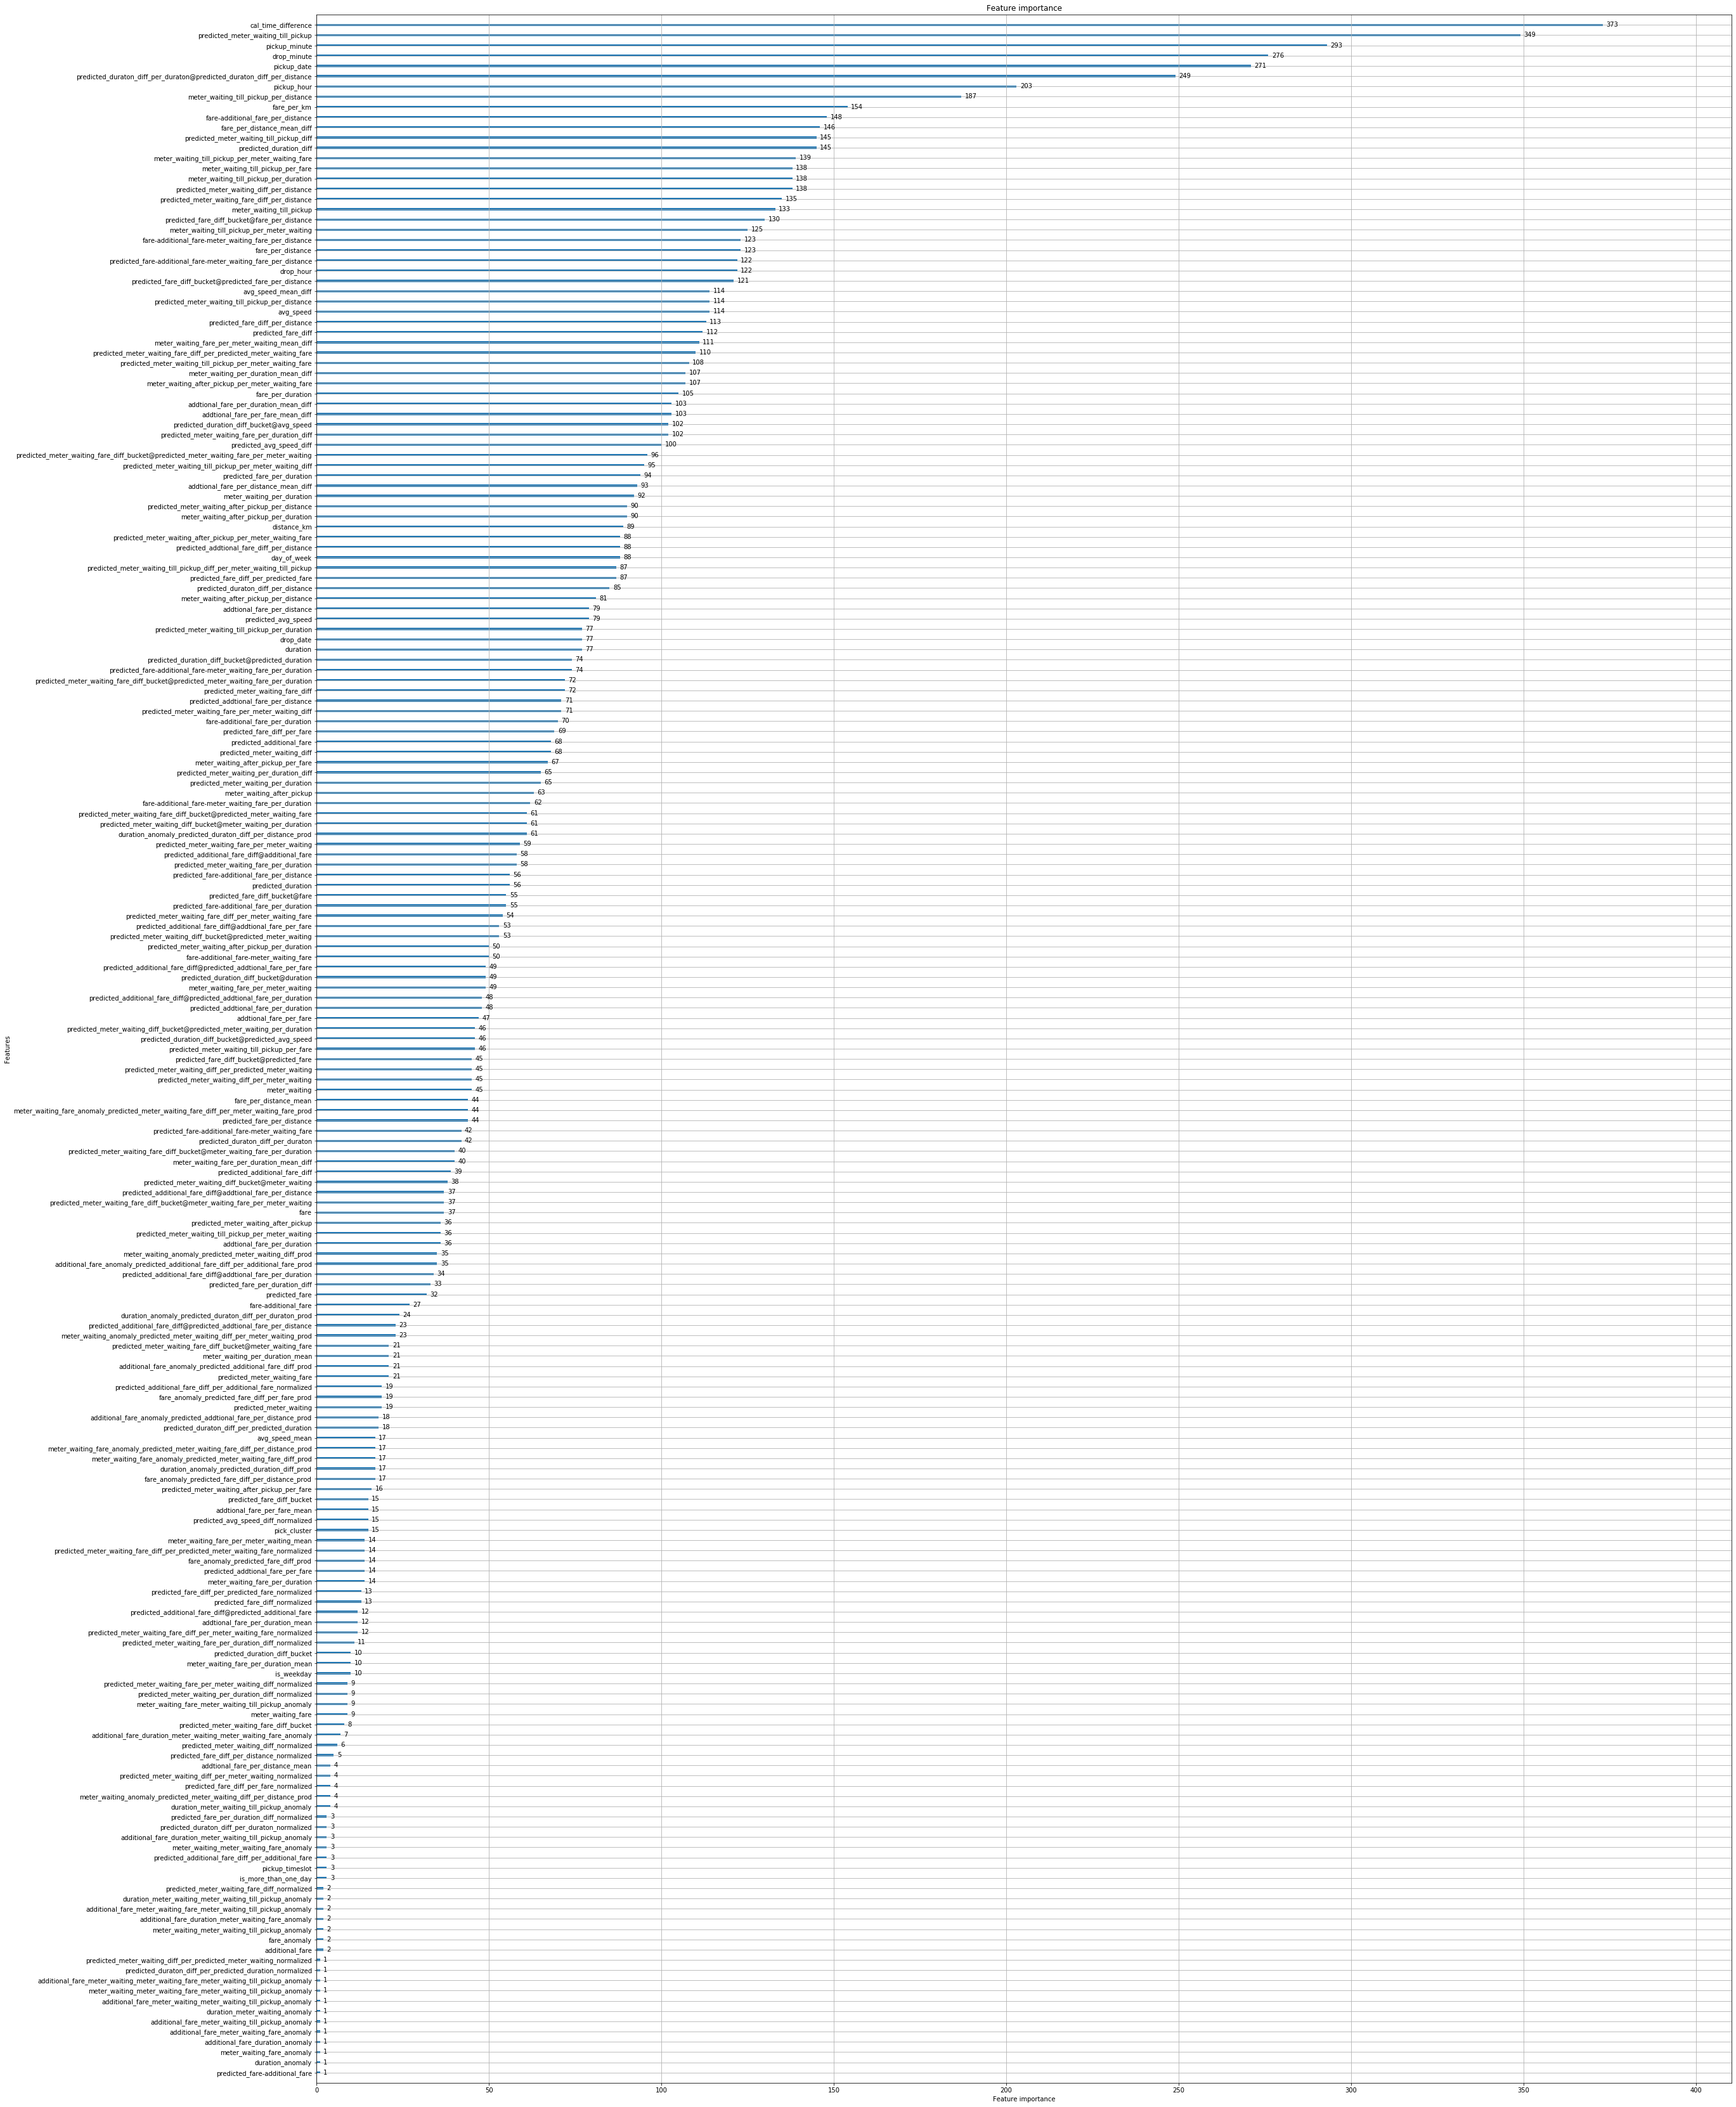

In [37]:
best_model = models[np.argmax(validation_scores)]

fig, ax = plt.subplots(figsize=(40, 60))
lgb.plot_importance(best_model,ax=ax)

In [40]:
submission_df['prediction'] = np.where(preds > 2.0, 1, 0)
submission_df['prediction'].sum() / submission_df.shape[0]

0.9379664179104478

In [41]:
submission_df.to_csv('submission.csv',index=False)